### ALFABURST Response to a Simulated FRB

The usable 56 MHz ALFABURST band and the RFI exciser put limits on the sensistivity to the system to detect FRBs. The limited abdn reduced the overall dedispersed sensitivity to broadband pulses. The RFI exciser potentially cuts flux from narrow width, low-DM, bright FRBs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedispersion
import seaborn as sns
import scipy.special
import scipy.signal

%matplotlib inline

In [2]:
sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 1.0})

#### Parameters

In [3]:
# FRB150807 - Spectra fully clipped - edges produce SNR ~29
#dm = 266.5
#width = 0.35 # ms
#speak = 128.0 # Jy

# FRB150418 - Partial channel clipping - SNR 89 -> ~74
#dm = 776.2
#width = 0.83 # ms
#speak = 2.19 # Jy

# FRB130628 - Partial channel clipping - SNR 81 -> ~70
#dm = 469.88
#width = 0.64 # ms
#speak = 1.91 # Jy

# FRB160317
#dm = 1165
#width = 21. # ms
#speak = 3. # Jy

# FRB170107 - Significant channel clipping - SNR 930 -> ~74
#dm = 609.5
#width = 2.60 # ms
#speak = 22.30 # Jy

# FRB170827 - Spectra fully clipped - edges produce SNR ~35
#dm = 176.4
#width = 0.40 # ms
#speak = 50.30 # Jy

# FRB170922
dm = 1111.
width = 26. # ms
speak = 60./26. # Jy

# ALFABURST RX
bw = 56. # MHz, processing bandwidth
nchan = 512 # number of frequency channels
f0 =  1456. # MHz, start frequency (low)
tInt = 0.256 # ms, time integration
tWindow = 300. # ms, time window of dynamic spectrum
SEFD = 3. # Jy, ALFA SEFD

#### FRB Dynamic Spectrum

In [4]:
freqsHz = (np.arange(nchan) * (bw / nchan) + f0) * 1e6
waterfall = np.zeros((int(tWindow / tInt), nchan))
print waterfall.shape

(1171, 512)


1.0


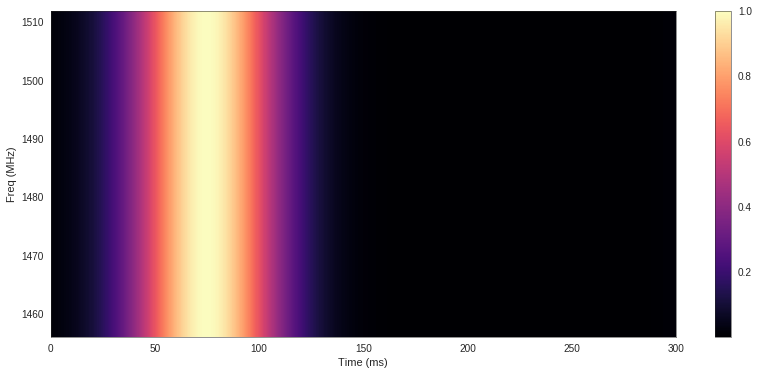

In [5]:
tIndStart = int(waterfall.shape[0] * 0.25) # index of start of pulse, start 25% into the dynamic spectrum
waterfall[tIndStart] = 1.

gaussResponse = scipy.signal.gaussian(waterfall.shape[0], width / tInt)
print gaussResponse.max()
gaussPSF = np.repeat(np.fft.fft(gaussResponse), waterfall.shape[1]).reshape(waterfall.shape[0], waterfall.shape[1])
waterfall = np.fft.fftshift(np.fft.ifft(np.fft.fft(waterfall, axis=0) * gaussPSF, axis=0), axes=0).real
# normalize to integrated flux=1
#waterfall /= waterfall[:, 0].sum()
waterfall /= waterfall.max()

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(14,6)) # (width, height)
plt.imshow(np.flipud(waterfall.T), interpolation='nearest', aspect='auto', cmap=plt.get_cmap(cmap), \
           extent=(0., tInt * waterfall.shape[0], freqsHz[0] / 1e6, freqsHz[-1] / 1e6))
plt.xlabel('Time (ms)')
plt.ylabel('Freq (MHz)')  
plt.colorbar()

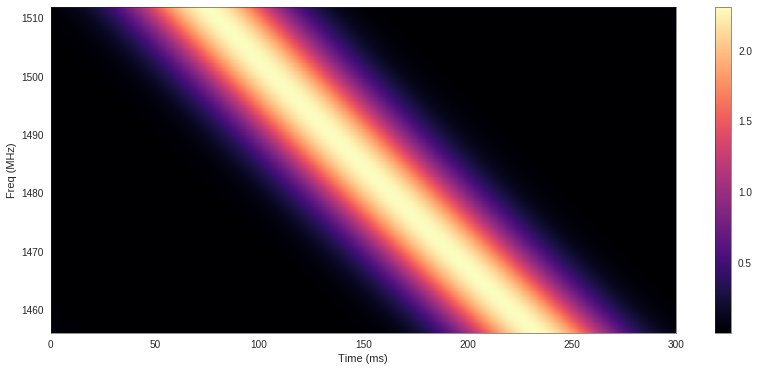

In [6]:
dwaterfall = dedispersion.incoherent(freqsHz, waterfall, tInt / 1000., -1. * dm, boundary='wrap') # apply dispersion

dwaterfall *= speak

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(14,6)) # (width, height)
plt.imshow(np.flipud(dwaterfall.T), interpolation='nearest', aspect='auto', cmap=plt.get_cmap(cmap), \
           extent=(0., tInt * dwaterfall.shape[0], freqsHz[0] / 1e6, freqsHz[-1] / 1e6))
plt.xlabel('Time (ms)')
plt.ylabel('Freq (MHz)')  
plt.colorbar()

#### Add System Noise

2.30769230769
0.0250802458277
0.566946709514


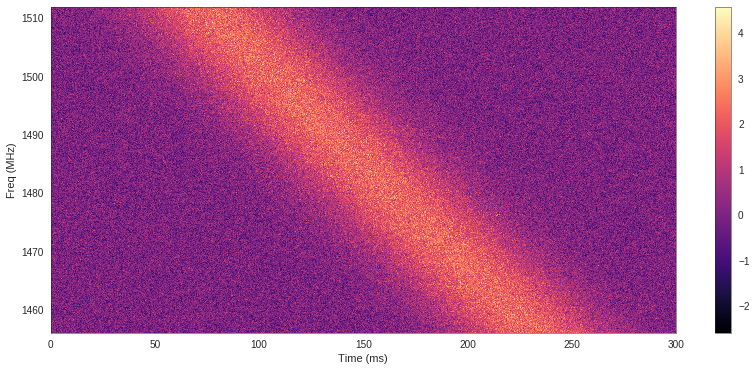

In [7]:
print dwaterfall.max()

print SEFD / np.sqrt((tInt / 1000.) * (freqsHz[-1] - freqsHz[0])) # full band, per time integration noise
perChanNoise = SEFD / np.sqrt((tInt / 1000.) * (freqsHz[1] - freqsHz[0])) # per channel, per time integration noise
print perChanNoise
dwaterfall += np.random.normal(0., perChanNoise, dwaterfall.shape)

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(14,6)) # (width, height)
plt.imshow(np.flipud(dwaterfall.T), interpolation='nearest', aspect='auto', cmap=plt.get_cmap(cmap), \
           extent=(0., tInt * dwaterfall.shape[0], freqsHz[0] / 1e6, freqsHz[-1] / 1e6))
plt.xlabel('Time (ms)')
plt.ylabel('Freq (MHz)')  
plt.colorbar()

#### Dedisperse

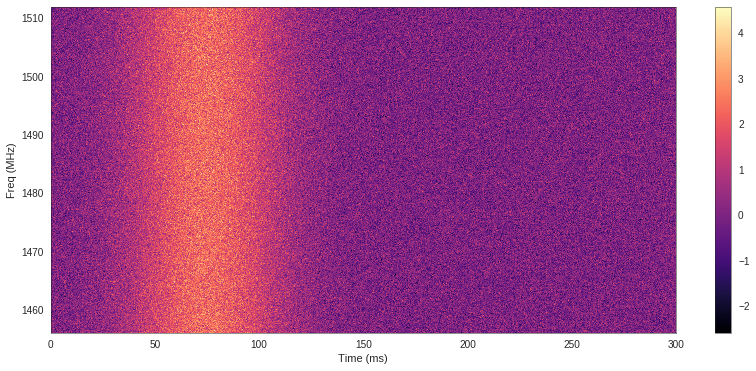

In [8]:
ddwaterfall = dedispersion.incoherent(freqsHz, dwaterfall, tInt / 1000., dm, boundary='wrap') # apply dedispersion

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(14,6)) # (width, height)
plt.imshow(np.flipud(ddwaterfall.T), interpolation='nearest', aspect='auto', cmap=plt.get_cmap(cmap), \
           extent=(0., tInt * ddwaterfall.shape[0], freqsHz[0] / 1e6, freqsHz[-1] / 1e6))
plt.xlabel('Time (ms)')
plt.ylabel('Freq (MHz)')  
plt.colorbar()

Peak Flux (Jy): 1197.75661955
Noise (Jy): 13.259913302
SNR: 90.3291441111


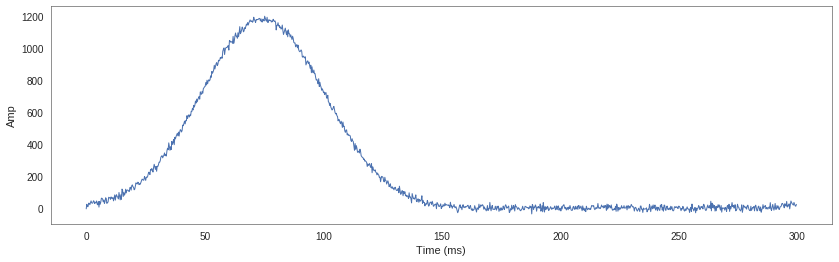

In [9]:
ddTimeSeries = np.sum(ddwaterfall, axis=1)
print 'Peak Flux (Jy):', ddTimeSeries.max()
print 'Noise (Jy):', ddTimeSeries[ddTimeSeries.shape[0]/2:].std()
print 'SNR:', ddTimeSeries.max() / ddTimeSeries[ddTimeSeries.shape[0]/2:].std()

fig = plt.figure(figsize=(14,4)) # (width, height)
plt.plot(tInt * np.arange(ddTimeSeries.shape[0]), ddTimeSeries)
plt.ylabel('Amp')
plt.xlabel('Time (ms)')

#### RFI Excision

In [10]:
threshChannel = 5.
threshSpectra = 10.

Values above channel clip threshold: 9096
(1171, 512) 599552


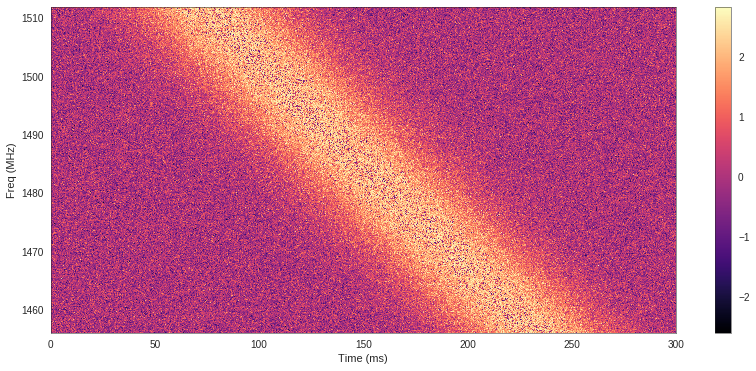

In [11]:
# Find channels with flux above threshChannel
chanIdx = np.argwhere(dwaterfall.flatten() > perChanNoise * threshChannel)
print 'Values above channel clip threshold:', chanIdx.size
print dwaterfall.shape, dwaterfall.size
dwaterfallFlat = dwaterfall.flatten()
dwaterfallFlat[chanIdx] = np.random.normal(0., perChanNoise, chanIdx.shape)
dwaterfall = dwaterfallFlat.reshape(dwaterfall.shape)

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(14,6)) # (width, height)
plt.imshow(np.flipud(dwaterfall.T), interpolation='nearest', aspect='auto', cmap=plt.get_cmap(cmap), \
           extent=(0., tInt * dwaterfall.shape[0], freqsHz[0] / 1e6, freqsHz[-1] / 1e6))
plt.xlabel('Time (ms)')
plt.ylabel('Freq (MHz)')  
plt.colorbar()

Peak Flux (Jy): 0.950489917763
Noise (Jy): 0.325373288259
SNR: 2.9212290992


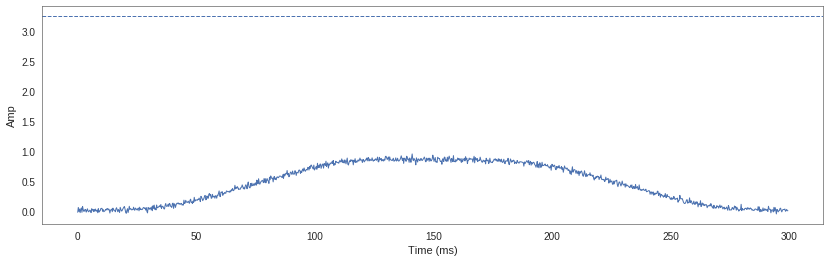

In [12]:
dTimeSeries = np.mean(dwaterfall, axis=1)
peakFlux = dTimeSeries.max()
print 'Peak Flux (Jy):', peakFlux
systemNoise = dTimeSeries[dTimeSeries.shape[0]/2:].std()
print 'Noise (Jy):', systemNoise
snr = dTimeSeries.max() / dTimeSeries[dTimeSeries.shape[0]/2:].std()
print 'SNR:', snr

fig = plt.figure(figsize=(14,4)) # (width, height)
plt.plot(tInt * np.arange(dTimeSeries.shape[0]), dTimeSeries)
plt.axhline(systemNoise * threshSpectra, ls='--')
plt.ylabel('Amp')
plt.xlabel('Time (ms)')

timeIdx = np.argwhere(dTimeSeries > systemNoise * threshSpectra)
for tIdx in timeIdx:
    dwaterfall[tIdx[0]] = np.random.normal(0., perChanNoise, nchan)

In [13]:
3. / np.sqrt((tInt / 1000.) * 56. * 1e6)

0.025055741429289787

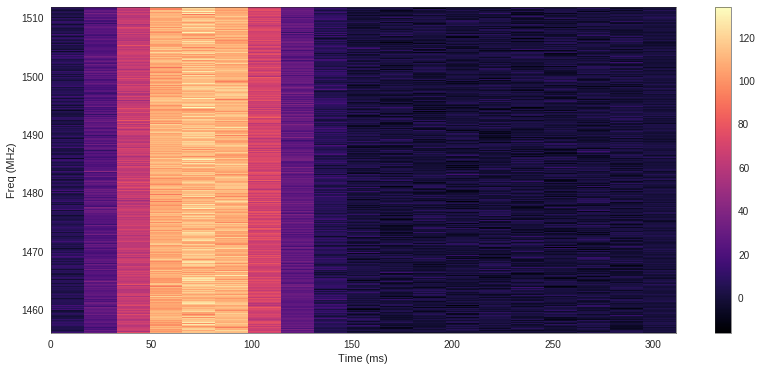

In [16]:
ddwaterfall = dedispersion.incoherent(freqsHz, dwaterfall, tInt / 1000., dm, boundary='wrap') # apply dedispersion

timeDecimate = True
timeFactor = 64
if timeDecimate:
    if ddwaterfall.shape[0] % timeFactor==0:
        decddwaterfall = ddwaterfall.reshape(ddwaterfall.shape[0]/timeFactor, timeFactor,\
                                             ddwaterfall.shape[1]).sum(axis=1)
        tInt *= timeFactor
    else:
        zeros = np.zeros((timeFactor - (waterfall.shape[0] % timeFactor), waterfall.shape[1]))
        decddwaterfall = np.concatenate((ddwaterfall, zeros))
        decddwaterfall = decddwaterfall.reshape(decddwaterfall.shape[0]/timeFactor, timeFactor,\
                                     decddwaterfall.shape[1]).sum(axis=1)
        tInt *= timeFactor
    
    ddwaterfall = decddwaterfall

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(14,6)) # (width, height)
plt.imshow(np.flipud(ddwaterfall.T), interpolation='nearest', aspect='auto', cmap=plt.get_cmap(cmap), \
           extent=(0., tInt * ddwaterfall.shape[0], freqsHz[0] / 1e6, freqsHz[-1] / 1e6))
plt.xlabel('Time (ms)')
plt.ylabel('Freq (MHz)')  
plt.colorbar()

Peak Flux (Jy): 112.9189442
Noise (Jy): 0.412638728005
SNR: 273.650863422


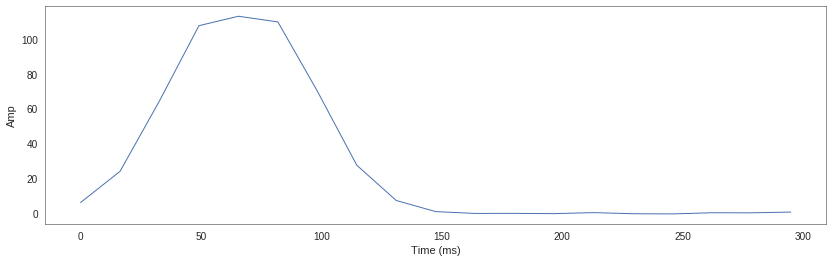

In [17]:
ddTimeSeries = np.mean(ddwaterfall, axis=1)
print 'Peak Flux (Jy):', ddTimeSeries.max()
print 'Noise (Jy):', ddTimeSeries[ddTimeSeries.shape[0]/2:].std()
print 'SNR:', ddTimeSeries.max() / ddTimeSeries[ddTimeSeries.shape[0]/2:].std()

fig = plt.figure(figsize=(14,4)) # (width, height)
plt.plot(tInt * np.arange(ddTimeSeries.shape[0]), ddTimeSeries)
#plt.plot(tInt * np.arange(ddTimeSeries.shape[0]), ddwaterfall[:,100])
plt.ylabel('Amp')
plt.xlabel('Time (ms)')